# Rover Project Notebook

This notebook contains the functions needed to test the mapping methods, as well as the main flow of the pipeline. 

In [23]:
%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio

## Looking at The Data Set Images 

This function reads and displays a random image from the test data set. 

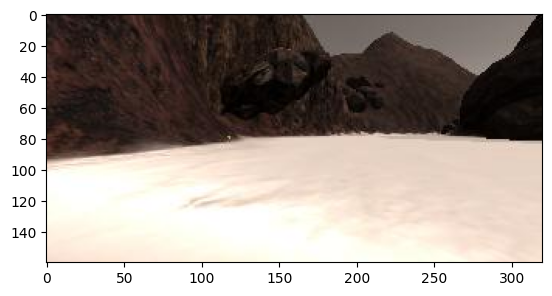

In [24]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data

This function reads and displays example grid and rock samples from calibration images data set. The grid and the rock samples are used next for perspective transform and the color selection in the colorThresh and rockThresh methods. 

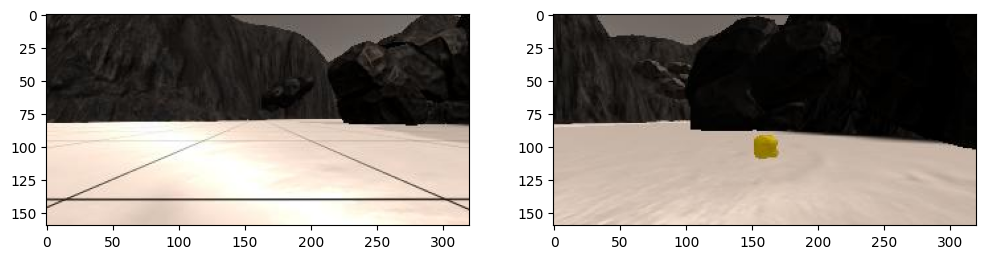

In [25]:
example_grid = '../calibration_images/example_grid1.jpg' #example for grid
example_rock = '../calibration_images/example_rock1.jpg' #example for rock
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Color Histogram 

This function plots the color histogram for the sample grid calibration image with all 3 channels in the same figure. The function is used to detect the threshold for the navigable terrain. From the figure, it is evident that the navigable pixels intensity is above 160 for all the channels. 

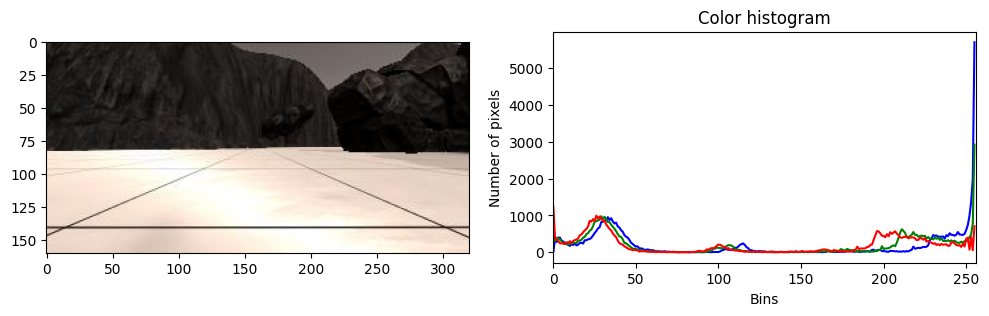

In [26]:
path =  '../calibration_images/example_grid1.jpg'
colorGridImg = cv2.imread(path)
colorGridImg=cv2.cvtColor(colorGridImg, cv2.COLOR_BGR2RGB)

chans=cv2.split(colorGridImg)
colors=("b", "g", "r")


fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(colorGridImg)
plt.subplot(122)

plt.title("Color histogram")
plt.xlabel("Bins")
plt.ylabel("Number of pixels")
for (chan, c) in zip(chans, colors):
    hist=cv2.calcHist([chan], [0], None, [256], [0,256])
    plt.plot(hist, color=c)
    plt.xlim([0,256])
plt.show()


## Perspective Transform

The perspective transform function is used to generate the bev view (warped image) of the vision image. 

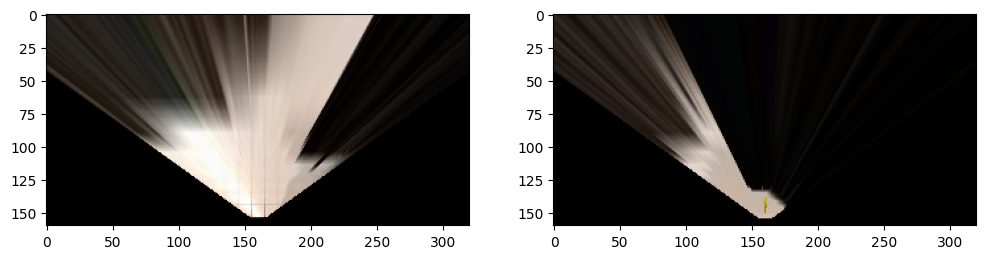

In [27]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    mask = cv2.warpPerspective(np.ones_like(img[:, :, 0]), M, (img.shape[1], img.shape[0]))
    
    return warped, mask

dst_size = 5  # each 10x10 pixel square in the grid represents 1 square meter
bottom_offset = 6 # the bottom of the image is not the position of the rover but a bit in front of it 

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, mask = perspect_transform(grid_img, source, destination)
warpedRock, mask = perspect_transform(rock_img, source, destination) 

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(warpedRock)


## Color Thresholding

The next functions are used to identify the navigable pixels and the rock pixels. Threshold of RGB > 160 does a nice job of identifying ground pixels only, while other range is used to detect the rock pixels. These threshold values are jusitified from the color histogram shown above. 

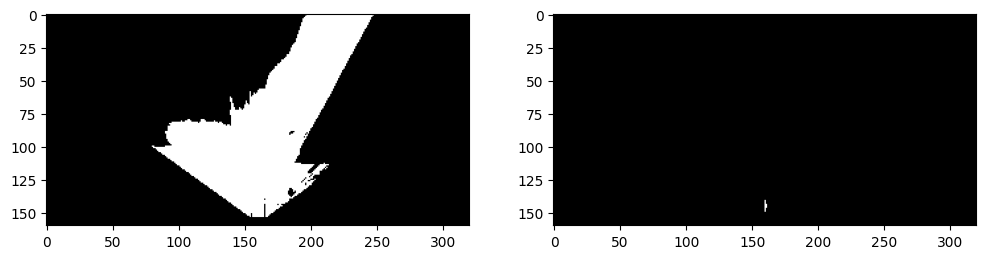

In [28]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = ( (img[:,:,0] > rgb_thresh[0]) \
        & (img[:,:,1] > rgb_thresh[1]) \
            & (img[:,:,2] > rgb_thresh [2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify rock pixels for certain threshold 
def rock_thresh(img, levels=(110, 110, 50)):
    rockpix = ( (img[:,:,0] > levels[0]) \
        & (img[:,:,1] > levels[1]) \
            & (img[:,:,2] < levels [2]))

    color_select = np.zeros_like(img[:,:,0])
    color_select[rockpix] = 1
    return color_select


threshed = color_thresh(warped)
rockPixels = rock_thresh(warpedRock)


fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(threshed, cmap='gray')
plt.subplot(122)
plt.imshow(rockPixels, cmap='gray')



## Coordinate Transformations

The functions used to do coordinate transforms in order to apply them to an image.

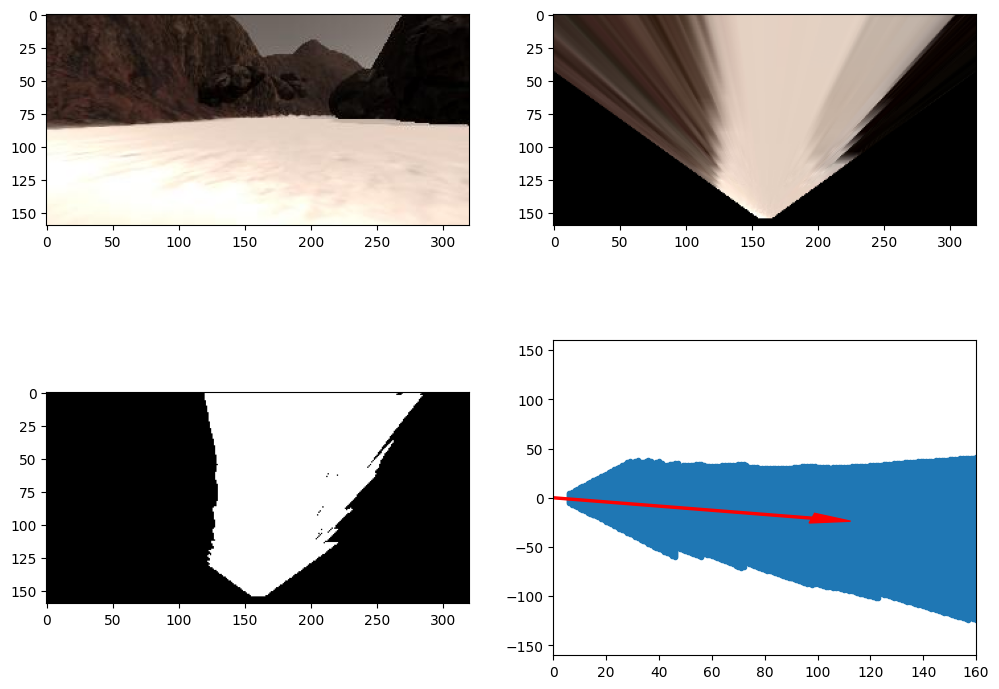

In [29]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world

The next cell is all setup to read the saved data and the truth map of the world. In the "ground truth" map of the world, white pixels (pixel value = 1) represent navigable terrain. These data are used afterwards in the "create_output_image" function

In [31]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float32)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float32)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

The next function includes the perception step processes. The following cell is all set up to use this create_output_image() function in conjunction with the moviepy video processing package to create a video from the images we saved taking data in the simulator.

Different individual images into create_output_image() to build an image called output_image that will be stored as one frame of video


In [32]:
# This function will be used by moviepy to create an output video
def create_output_image(img):

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5
    bottom_offset = 6
    src = np.float32([[14, 140], [300, 140], [200, 96], [118, 96]])
    dst = np.float32([
        [img.shape[1] / 2 - dst_size, img.shape[0] - bottom_offset],
        [img.shape[1] / 2 + dst_size, img.shape[0] - bottom_offset],
        [img.shape[1] / 2 + dst_size, img.shape[0] - 2 * dst_size - bottom_offset],
        [img.shape[1] / 2 - dst_size, img.shape[0] - 2 * dst_size - bottom_offset]])

    
    # 2) Apply perspective transform
    warped, mask = perspect_transform(img=img, src=src, dst=dst)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable_pixels = color_thresh(warped)
    obstacle_pixels = np.abs(np.float32(navigable_pixels) - 1) * mask
    rock_pixels = rock_thresh(img=warped, levels=(110, 110, 50))
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    x_nav, y_nav = rover_coords(binary_img=navigable_pixels)
    x_obs, y_obs = rover_coords(binary_img=obstacle_pixels)
    x_rock, y_rock = rover_coords(binary_img=rock_pixels)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = dst_size * 2
    x_rov_pos = data.xpos[data.count]
    y_rov_pos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    worldmap_size = data.worldmap.shape[0]

    x_nav_world, y_nav_world = pix_to_world(
        xpix=x_nav, ypix=y_nav,
        xpos=x_rov_pos, ypos=y_rov_pos, yaw=yaw, world_size=worldmap_size, scale=scale)
    x_obs_world, y_obs_world = pix_to_world(
        xpix= x_obs, ypix= y_obs,
        xpos=x_rov_pos, ypos=y_rov_pos, yaw=yaw, world_size=worldmap_size, scale=scale)
    x_rock_world, y_rock_world = pix_to_world(
        xpix=x_rock, ypix=y_rock,
        xpos=x_rov_pos, ypos=y_rov_pos, yaw=yaw, world_size=worldmap_size, scale=scale)
    
    
    
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    data.worldmap[y_obs_world, x_obs_world, 0] = 255
    data.worldmap[y_nav_world, x_nav_world, 2] = 255
    if rock_pixels.any():
        data.worldmap[y_rock_world, x_rock_world, :] = 255

    #Resolve the overlap between navigable pixels and obstacles pixels. Note, another approach is used in the supporing functions.   
    nav_pix = data.worldmap[:, :, 2] > 0 
    data.worldmap[nav_pix, 0] = 0 
    
    # 7) Make a mosaic image, below is some example code
    
    # create a blank image
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    
    # Put the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    warped, mask = perspect_transform(img, source, destination)
    
    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

     # put some text over the image
    cv2.putText(output_image,"Video to show different stages of the code!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data  

Use the moviepy library to process images and create an output video.

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(create_output_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
CPU times: user 964 ms, sys: 182 ms, total: 1.15 s
Wall time: 1.28 s


### This next cell should function as an inline video player

In [34]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))